In [1]:
!pip install icecream
!pip install datasets
!pip install transformers==4.13.0

     |████████████████████████████████| 298 kB 4.4 MB/s 
     |████████████████████████████████| 243 kB 41.8 MB/s 
     |████████████████████████████████| 132 kB 52.3 MB/s 
     |████████████████████████████████| 61 kB 512 kB/s 
     |████████████████████████████████| 1.1 MB 35.3 MB/s 
     |████████████████████████████████| 271 kB 42.1 MB/s 
     |████████████████████████████████| 160 kB 42.3 MB/s 
     |████████████████████████████████| 192 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 40.6 MB/s 
     |████████████████████████████████| 895 kB 37.3 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install pyarrow

In [3]:
from icecream import ic
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
import pyarrow as pa

from tqdm import tqdm
import random

In [ ]:
CONFIG ={
    "epochs": 100,
    "batch_size": 32,
    "learning_rate": 0.1,
    "hidden_size": 128,
    "n_layers": 2,
    "drop_prob": 0.3,
    "embedding_size": 64
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
train = load_dataset("squad", split='train')
test = load_dataset("squad", split='validation')

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/8.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


In [12]:
for i in range(500):
  print(train[i]['context'])

Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
type(train)

datasets.arrow_dataset.Dataset

In [ ]:
len(tokenizer)

28996

In [ ]:
train_answers = []
for t in train['answers']:
    if t['text'] != None:
        train_answers.append(t['text'][0])

In [ ]:
test_answers = []
for t in test['answers']:
    if t['text'] != None:
        test_answers.append(t['text'][0])

In [ ]:
test = test.add_column("ans", test_answers)

In [ ]:
train = train.add_column("ans", train_answers)

In [ ]:
test

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'ans'],
    num_rows: 10570
})

In [ ]:
def get_loader(data, part):
    dataset = data.map(lambda e: tokenizer(e[part], truncation=True, max_length=64, padding='max_length'), batched=True)
    dataset.set_format(type='torch', columns=['input_ids'])
    loader = torch.utils.data.DataLoader(dataset, batch_size=CONFIG["batch_size"])
    return loader

In [ ]:
c_loader_train = get_loader(train, 'context')
c_loader_test = get_loader(test, 'context')
q_loader_train = get_loader(train, 'question')
q_loader_test = get_loader(test, 'question')
a_loader_train = get_loader(train, 'ans')
a_loader_test = get_loader(test, 'ans')

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_layer, embedding_layer, hidden_layer, num_layers, dropout):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_layer
    self.num_layers = num_layers
    self.embedding = nn.Embedding(2*input_layer, embedding_layer)
    self.lstm = nn.LSTM(embedding_layer, hidden_layer, num_layers, bidirectional=True, dropout=dropout, batch_first=True)
  
  def forward(self, source, answer):
    source = source.to(device)
    source = torch.cat((source, answer), dim=1)
    embed_source = self.embedding(source)
    output, (hidden, cell) = self.lstm(embed_source)
    return output, hidden, cell

In [ ]:
encoder = Encoder(input_layer = len(tokenizer),
                  embedding_layer = CONFIG["embedding_size"],
                  hidden_layer = CONFIG["hidden_size"],
                  num_layers = CONFIG["n_layers"],
                  dropout = CONFIG["drop_prob"]).to(device)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dimension):
        super(Attention, self).__init__()
        self.hidden_dimension = hidden_dimension
        self.attention = nn.Linear(3*self.hidden_dimension, hidden_dimension)
        self.energy = nn.Linear(self.hidden_dimension, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, hidden, outputs):
        # ic(hidden.shape, outputs.shape)
        seq = outputs.shape[1]
        hidden = hidden[-1, :, :]
        hidden = hidden.unsqueeze(1)
        hidden = hidden.repeat(1, seq, 1)
        # ic(len(outputs.shape), len(hidden.shape))
        attention = self.attention(torch.cat((hidden, outputs), dim=2))
        energies = self.energy(attention)
        energies = energies.squeeze(2)
        soft = self.softmax(energies)
        outputs = outputs.permute(0, 2, 1)
        soft = soft.unsqueeze(2)
        weights = outputs@soft
        weights = weights.permute(0, 2, 1)
        return weights

In [ ]:
attention = Attention(CONFIG['hidden_size'])

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_layer, embedding_layer, hidden_layer, output_layer, num_layers, dropout, attention):
    super(Decoder, self).__init__()
    self.num_layers = num_layers
    self.hidden_layers = hidden_layer
    self.embedding = nn.Embedding(input_layer, embedding_layer)
    self.lstm = nn.LSTM(embedding_layer, hidden_layer, 2*num_layers, dropout=dropout, batch_first=True)
    self.fc_out = nn.Linear(hidden_layer, output_layer)
    self.dropout = nn.Dropout(dropout)
    self.attention = attention
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, source, target, hidden, cell):
    source = source.unsqueeze(1)
    embed_source = self.embedding(source)
    embed_source = self.dropout(embed_source)
    weights = self.attention(hidden, target)
    output, (hidden, cell) = self.lstm(embed_source, (hidden, cell))
    prediction = self.fc_out(output.squeeze(1))
    prediction = self.softmax(prediction)
    return prediction, hidden, cell

In [ ]:
decoder = Decoder(input_layer = len(tokenizer),
                  embedding_layer = CONFIG["embedding_size"],
                  hidden_layer = CONFIG["hidden_size"],
                  output_layer = len(tokenizer),
                  num_layers = CONFIG["n_layers"],
                  dropout = CONFIG["drop_prob"],
                  attention = attention).to(device)

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, tokenizer, teacher_force=0.3):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.tokenizer = tokenizer
    self.tf = teacher_force

  def forward(self, source, target, answer):
    eoutput, hidden, cell = self.encoder(source, answer)
    input = target[:,0].to(device)
    d_outputs = torch.zeros(
        target.size(1) - 1,
        CONFIG['batch_size'],
        len(self.tokenizer)
    ).to(device)

    for t in range(1, target.size(1)):
        output, hidden, cell = self.decoder(input, eoutput, hidden, cell)
        d_outputs[t-1] = output.to(device)
        tf_output = random.random() < self.tf
        predict = output.argmax(-1).to(device)
        input = target[:, t] if tf_output else predict

    return d_outputs

In [ ]:
model = Seq2Seq(encoder, decoder, tokenizer).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids('[PAD]'))

In [ ]:
epochs = 1
iterations = 100
count = 0

In [ ]:
# for (context_id, context), (question_id, question) in tqdm(zip(enumerate(c_loader_train), enumerate(q_loader_train))):
bloss = []
for _ in range(epochs):
    c_gen = iter(c_loader_train)
    q_gen = iter(q_loader_train)
    a_gen = iter(a_loader_train)
    for i in tqdm(range(iterations)):
        try:
            context = next(c_gen)
            question = next(q_gen)
            answer = next(a_gen)
            count += 1
        except StopIteration:
            break
        source = context['input_ids'].to(device)
        target = question['input_ids'].to(device)
        answer = answer['input_ids'].to(device)
        outputs = model(source, target, answer)
        if count == iterations*epochs - 1:
            trial = torch.argmax(outputs, axis=2)
            # ic(trial, outputs)
            # ic(tokenizer.batch_decode(source))
            # ic(tokenizer.batch_decode(target))
            # ic(tokenizer.batch_decode(answer))
            ic(tokenizer.batch_decode(trial))
        optimizer.zero_grad()
        outputs = outputs.permute(1, 2, 0)
        target = target[:, 1:]
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        bloss.append(loss.item())

 98%|█████████▊| 98/100 [01:26<00:01,  1.13it/s]ic| tokenizer.batch_decode(trial): ['What What What What What What What What What What What What What What What '
                                    'What What What What What What What What What What What What What What What '
                                    'What What',
                                    'What What What What What What What What What What What What What What What '
                                    'What What What What What What What What What What What What What What What '
                                    'What What',
                                    'the the the the the the the the the the the the the the the the the the the '
                                    'the the the the the the the the the the the the the',
                                    'the the the the the the the the the the the the the the the the the the the '
                                    'the the the the the the the the the the 

In [ ]:
import matplotlib.pyplot as plt

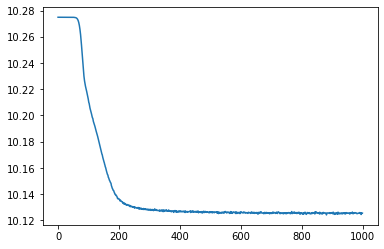

In [ ]:
plt.plot(bloss)
plt.show()

In [ ]:
# for (context_id, context), (question_id, question) in tqdm(zip(enumerate(c_loader_train), enumerate(q_loader_train))):
bloss = []
for i in range(1):
    try:
        context = next(c_gen)
        question = next(q_gen)
    except StopIteration:
        break
    source = context['input_ids']
    target = question['input_ids']
    outputs = model(source, target)
    ic(outputs.shape)
    ic(outputs)
    outputs = torch.argmax(outputs, axis=2)
    ic(outputs.shape)
    ic(outputs)

ic| outputs.shape: torch.Size([64, 32, 28996])
ic| outputs: tensor([[[0.9906, 0.1417, 0.1602,  ..., 0.1198, 0.2176, 0.1116],
                      [0.9905, 0.1403, 0.1601,  ..., 0.1207, 0.2200, 0.1126],
                      [0.9903, 0.1452, 0.1599,  ..., 0.1211, 0.2167, 0.1151],
                      ...,
                      [0.9903, 0.1413, 0.1623,  ..., 0.1217, 0.2188, 0.1135],
                      [0.9906, 0.1418, 0.1571,  ..., 0.1186, 0.2248, 0.1118],
                      [0.9907, 0.1395, 0.1623,  ..., 0.1162, 0.2266, 0.1121]],
             
                     [[0.9931, 0.1200, 0.1438,  ..., 0.1068, 0.2037, 0.1002],
                      [0.9932, 0.1188, 0.1425,  ..., 0.1063, 0.2019, 0.0970],
                      [0.9929, 0.1217, 0.1440,  ..., 0.1071, 0.1993, 0.1007],
                      ...,
                      [0.9931, 0.1198, 0.1422,  ..., 0.1074, 0.2008, 0.1004],
                      [0.9931, 0.1215, 0.1420,  ..., 0.1083, 0.2077, 0.0989],
                      [0.9